In [1]:
import os
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram, CountVectorizer, IDF, VectorAssembler
from pyspark.sql.functions import regexp_replace, lower, col
from pyspark.ml.feature import HashingTF
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import hour, dayofweek, month, year, weekofyear



/Users/camillecu/anaconda3/envs/my_environment/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# load data

In [2]:


data = []

# Loop through all files in the Spark_test folder
for foldername, subfolders, filenames in os.walk('/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories'):
    for filename in filenames:
        # Check if the file is a .file and starts with 'part-'
        if filename.startswith('part-'):
            filepath = os.path.join(foldername, filename)
            print(filepath)
            # Open the file and parse each line as a JSON object
            with open(filepath, 'r') as f:
                for line in f:
                    obj = json.loads(line)
                    # Extract the required fields and append to the data list
                    data.append({
                        'aid': obj['aid'],
                        'title': obj['title'],
                        'url': obj['url'],
                        'domain': obj['domain'],
                        'user': obj['user'],
                        'posted_at': obj['posted_at'],
                        'comments': obj['comments'],
                        'source_title': obj['source_title'],
                        'source_text': obj['source_text'],
                        'frontpage': obj['frontpage'],
                    })



/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00017
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00028
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00010
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00026
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00019
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00021
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/par

In [3]:
# Convert the data list to a PySpark DataFrame
spark = SparkSession.builder.appName('reddit').getOrCreate()
df = spark.createDataFrame(data)

24/05/25 21:07:29 WARN Utils: Your hostname, Camilles-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.100 instead (on interface en0)
24/05/25 21:07:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/25 21:07:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/25 21:07:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/25 21:07:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
df.show()

24/05/25 21:07:39 WARN TaskSetManager: Stage 0 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|     aid|comments|              domain|frontpage|          posted_at|         source_text|        source_title|               title|                 url|          user|
+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|40334426|       0|        slashdot.org|    false|2024-05-12 13:47:02|The People Who Wo...|The People Who Wo...|Floppies are stil...|https://hardware....|         bindd|
|40334484|       0|       sibylline.dev|    false|2024-05-12 13:53:21|Artificial Genera...|Artificial Genera...|Is AGI a Red Herr...|https://sibylline...|    CuriouslyC|
|40334503|       0|      github.com/orf|    false|2024-05-12 13:54:27|GitHub - orf/pyve...|GitHub - orf/pyve...|Show HN: Pyvector...|https://github.co

In [5]:

# Set up session
spark = SparkSession.builder.appName('nlp').getOrCreate()

24/05/25 21:07:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Preprocessing data
- lowercase
- remove special characters
- fill na value

In [6]:
# Initialize SparkSession
spark = SparkSession.builder.appName('preprocessing').getOrCreate()

# matches any character that is not a letter, digit, or whitespace with an empty string
# converts all characters to lowercase
def preprocess(df, column):
    df = df.withColumn(column, lower(regexp_replace(column, '[^\\sa-zA-Z0-9]', '')))
    df = df.fillna('null')
    return df

df = preprocess(df, 'title')
df = preprocess(df, 'source_title')
df = preprocess(df, 'source_text')
df = preprocess(df, 'user')

24/05/25 21:07:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
# convert fromtpage to binary
df = df.withColumn('frontpage', df['frontpage'].cast('int'))
# convert convert 'posted_at' to a timestamp type
df = df.withColumn('posted_at', df['posted_at'].cast('timestamp'))

In [38]:
# count number of distinct value in frontpage
df.groupBy('frontpage').count().show()

24/05/25 22:50:52 WARN TaskSetManager: Stage 190 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----+
|frontpage|count|
+---------+-----+
|        1|  776|
|        0| 3028|
+---------+-----+



In [8]:
df.show()

24/05/25 21:07:44 WARN TaskSetManager: Stage 1 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|     aid|comments|              domain|frontpage|          posted_at|         source_text|        source_title|               title|                 url|          user|
+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|40334426|       0|        slashdot.org|        0|2024-05-12 13:47:02|the people who wo...|the people who wo...|floppies are stil...|https://hardware....|         bindd|
|40334484|       0|       sibylline.dev|        0|2024-05-12 13:53:21|artificial genera...|artificial genera...|is agi a red herring|https://sibylline...|    curiouslyc|
|40334503|       0|      github.com/orf|        0|2024-05-12 13:54:27|github  orfpyvect...|github  orfpyvect...|show hn pyvectorr...|https://github.co

### train test split

In [9]:
trainData, testData = df.randomSplit([0.7, 0.3], seed=0)

# Feature Engineering

### process source_title, title, source_text

In [12]:


def process_column(df_train, df_test, column_name):
    # Tokenize the column
    tokenizer = Tokenizer(inputCol=column_name, outputCol=column_name + '_words')
    df_train_tokenized = tokenizer.transform(df_train)
    df_test_tokenized = tokenizer.transform(df_test)

    # Remove stop words
    stop_words = StopWordsRemover.loadDefaultStopWords('english')
    stop_words_remover = StopWordsRemover(inputCol=column_name + '_words', outputCol=column_name + '_filtered_words', stopWords=stop_words)
    df_train_tokenized = stop_words_remover.transform(df_train_tokenized)
    df_test_tokenized = stop_words_remover.transform(df_test_tokenized)

    # Generate ngrams
    ngram = NGram(n=2, inputCol=column_name + '_filtered_words', outputCol=column_name + '_ngrams')
    df_train_tokenized = ngram.transform(df_train_tokenized)
    df_test_tokenized = ngram.transform(df_test_tokenized)

    # Combine tokenized words and ngrams into a single column using array
    #df_train_combined = df_train_tokenized.withColumn(column_name + '_grams', array(col(column_name + '_filtered_words'), col(column_name + '_ngrams')))
    #df_test_combined = df_test_tokenized.withColumn(column_name + '_grams', array(col(column_name + '_filtered_words'), col(column_name + '_ngrams')))

    # Apply CountVectorizer
    cv = CountVectorizer(inputCol=column_name + '_ngrams', outputCol=column_name + '_features', vocabSize=1000)
    cv_model = cv.fit(df_train_tokenized)
    df_train_featurized = cv_model.transform(df_train_tokenized)
    df_test_featurized = cv_model.transform(df_test_tokenized)

    # Apply IDF
    idf = IDF(inputCol=column_name + '_features', outputCol=column_name + '_tfidf_features')
    idf_model = idf.fit(df_train_featurized)
    df_train_rescaled = idf_model.transform(df_train_featurized)
    df_test_rescaled = idf_model.transform(df_test_featurized)
    
    return df_train_rescaled, df_test_rescaled




In [13]:
trainData, testData = process_column(trainData, testData, 'source_title')
trainData, testData = process_column(trainData, testData, 'title')
trainData, testData = process_column(trainData, testData, 'source_text')

24/05/25 21:12:03 WARN StopWordsRemover: Default locale set was [en_CN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
24/05/25 21:12:04 WARN TaskSetManager: Stage 2 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:12:16 WARN TaskSetManager: Stage 6 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:12:25 WARN StopWordsRemover: Default locale set was [en_CN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
24/05/25 21:12:25 WARN TaskSetManager: Stage 8 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:12:30 WARN TaskSetManager: Stage 12 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 

In [15]:
# drop the columns: source_text, source_title, title,  title_features, source_title_features, source_text_features
rescaled_train = trainData.drop('source_text', 'source_title', 'title', 'title_words', 'source_title_words', 'source_text_words', 'title_features', 'source_title_features', 'source_text_features')
rescaled_test = testData.drop('source_text', 'source_title', 'title', 'title_words', 'source_title_words', 'source_text_words', 'title_features', 'source_title_features', 'source_text_features')
# drop aid and url
rescaled_train = rescaled_train.drop('aid', 'url')
rescaled_test = rescaled_test.drop('aid', 'url')

###  Handling Categorical Columns (domain, user)

In [16]:


# Function to process categorical columns with StringIndexer
def process_categorical_columns_with_indexer(df_train, df_test, categorical_cols):
    # initializes an empty list to store the stages of the pipeline
    stages = []
    
    for col in categorical_cols:
        # creates a StringIndexer for the column with the handleInvalid parameter set to 'skip' to ignore unseen labels
        indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid='skip')
        # adds the indexer to the list of stages
        stages += [indexer]
    
    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df_train)
    df_train = pipeline_model.transform(df_train)
    df_test = pipeline_model.transform(df_test)
    
    return df_train, df_test



In [17]:
categorical_cols = ['domain', 'user']
processed_train, processed_test = process_categorical_columns_with_indexer(rescaled_train, rescaled_test, categorical_cols)

24/05/25 21:18:07 WARN TaskSetManager: Stage 20 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:18:13 WARN TaskSetManager: Stage 23 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


In [18]:
# Function to process timestamp column
def process_timestamp_column(df, column):
    df = df.withColumn(column + "_hour", hour(df[column]))
    df = df.withColumn(column + "_dayofweek", dayofweek(df[column]))
    df = df.withColumn(column + "_month", month(df[column]))
    df = df.withColumn(column + "_year", year(df[column]))
    return df

# Process timestamp column
train_final = process_timestamp_column(processed_train, 'posted_at')
test_final = process_timestamp_column(processed_test, 'posted_at')

In [19]:
# drop  posted_at, user, domain columns from the train and test data
train_final = train_final.drop('posted_at', 'user', 'domain')
test_final = test_final.drop('posted_at', 'user', 'domain')

In [20]:
# Function to assemble features into a single vector
#def assemble_features(df, feature_cols, output_col='features'):
#    assembler = VectorAssembler(inputCols=feature_cols, outputCol=output_col)
#    df = assembler.transform(df)
#    return df

In [21]:
train_final.show()

24/05/25 21:18:19 WARN TaskSetManager: Stage 26 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


+--------+---------+---------------------------+--------------------+---------------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------------+--------------+------------+--------------+-------------------+---------------+--------------+
|comments|frontpage|source_title_filtered_words| source_title_ngrams|source_title_tfidf_features|title_filtered_words|        title_ngrams|title_tfidf_features|source_text_filtered_words|  source_text_ngrams|source_text_tfidf_features|domain_indexed|user_indexed|posted_at_hour|posted_at_dayofweek|posted_at_month|posted_at_year|
+--------+---------+---------------------------+--------------------+---------------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------------+--------------+------------+--------------+-------------------+---------------+--------------+
|       0|

# Feature Selection - ChiSqSelector

In [24]:
from pyspark.ml.feature import VectorAssembler, ChiSqSelector
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName('feature_selection').getOrCreate()

# Combine features into a single vector column
assembler = VectorAssembler(
    inputCols=[
        'comments',
        'source_title_tfidf_features',
        'title_tfidf_features',
        'source_text_tfidf_features',
        'domain_indexed',
        'user_indexed',
        'posted_at_hour',
        'posted_at_dayofweek',
        'posted_at_month',
        'posted_at_year'
    ],
    outputCol='features'
)
train_feature = assembler.transform(train_final)
test_feature = assembler.transform(test_final)

# Apply ChiSqSelector
selector = ChiSqSelector(
    numTopFeatures=3, 
    featuresCol="features", 
    outputCol="selectedFeatures", 
    labelCol="frontpage"
)

selector_model = selector.fit(train_feature)
train_selected = selector_model.transform(train_feature)
test_selected = selector_model.transform(test_feature)

24/05/25 21:23:38 WARN TaskSetManager: Stage 27 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:23:39 WARN TaskSetManager: Stage 28 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:23:50 WARN TaskSetManager: Stage 30 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


In [26]:
# map the selected features to the original feature names

selected_indices = selector_model.selectedFeatures

# Print the selected features
print("Selected feature indices: ", selected_indices)

selected_features = selector_model.selectedFeatures
feature_names = [
    'comments',
    'source_title_tfidf_features',
    'title_tfidf_features',
    'source_text_tfidf_features',
    'combined_tfidf_features',
    'domain_indexed',
    'user_indexed',
    'posted_at_hour',
    'posted_at_dayofweek',
    'posted_at_month',
    'posted_at_year'
]
# Flatten the feature names to match the indices
flattened_feature_names = []
for name in feature_names:
    if 'tfidf_features' in name:
        # Assuming each TF-IDF feature is a vector of 1000 elements
        flattened_feature_names.extend([name + f"_{i}" for i in range(10000)])
    else:
        flattened_feature_names.append(name)

# Map selected indices back to the original feature names
selected_feature_names = [flattened_feature_names[i] for i in selected_indices]

# Print the selected feature names
print("Selected feature names: ", selected_feature_names)




Selected feature indices:  [0, 2156, 2397]
Selected feature names:  ['comments', 'source_title_tfidf_features_2155', 'source_title_tfidf_features_2396']


# Train M

## Gradient-boosted tree classifier

In [27]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [29]:
# Train a GBT model.
gbt = GBTClassifier(labelCol="frontpage", featuresCol="selectedFeatures", maxIter=10)
# Train model
model = gbt.fit(train_selected)
# Make predictions.
predictions = model.transform(test_selected)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="frontpage", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print('accuracy is:', accuracy)


24/05/25 21:46:31 WARN TaskSetManager: Stage 32 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:46:32 WARN TaskSetManager: Stage 33 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:46:44 WARN TaskSetManager: Stage 34 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:46:54 WARN TaskSetManager: Stage 36 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:03 WARN TaskSetManager: Stage 38 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:03 WARN TaskSetManager: Stage 40 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:03 WARN TaskSetManager: Stage 42 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/

accuracy is: 0.8062015503875969


In [30]:
# Confusion matrix
y_true = predictions.select(['frontpage']).collect()
y_pred = predictions.select(['prediction']).collect()
confusion_matrix(y_true, y_pred)



24/05/25 21:47:20 WARN TaskSetManager: Stage 138 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:25 WARN TaskSetManager: Stage 139 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


array([[286,   5],
       [ 70,  26]])

24/05/25 21:47:30 WARN TaskSetManager: Stage 140 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


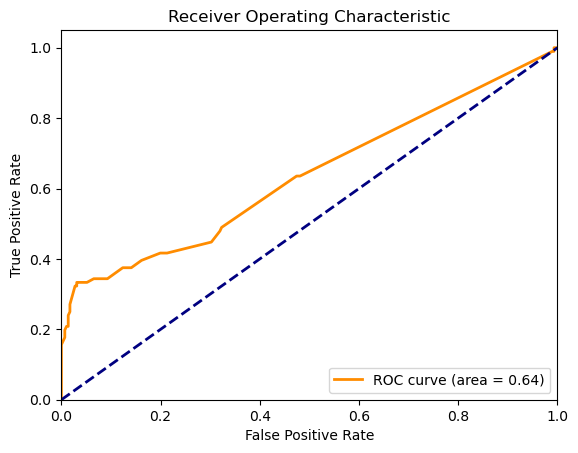

In [31]:
# ROC curve
y_prob = predictions.select(['probability']).collect()
y_prob = np.array([x[0][1] for x in y_prob])
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression - combined text features

In [32]:
lr = LogisticRegression(labelCol="frontpage", featuresCol="selectedFeatures")
lrModel = lr.fit(train_selected)
predictions = lrModel.transform(test_selected)
# predictions.show()
# predictions.select('probability', 'frontpage', 'prediction').show(truncate=False)

24/05/25 21:47:38 WARN TaskSetManager: Stage 141 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:48 WARN TaskSetManager: Stage 143 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:58 WARN TaskSetManager: Stage 145 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:58 WARN TaskSetManager: Stage 147 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:59 WARN TaskSetManager: Stage 149 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:59 WARN TaskSetManager: Stage 151 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:47:59 WARN TaskSetManager: Stage 153 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.

24/05/25 21:48:01 WARN TaskSetManager: Stage 167 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


AUC:  0.6398374856815578


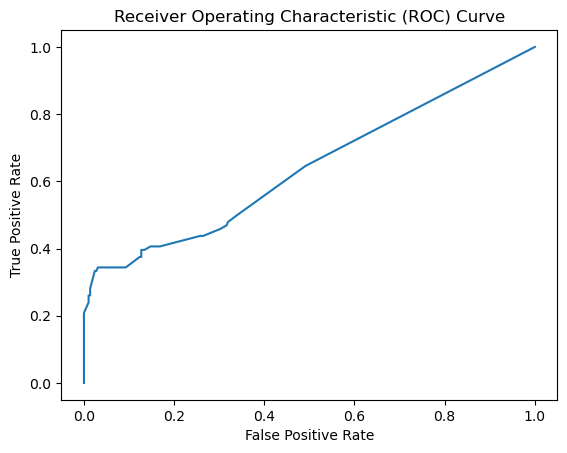

In [33]:
pandas_df = predictions.select('frontpage','probability','prediction').toPandas()
labels = pandas_df['frontpage']
predicted = pandas_df['prediction']
probabilities = pandas_df['probability'].apply(lambda x: x[1])


# AUC/ROC
fpr, tpr, thresholds = roc_curve(labels, probabilities)
plt.plot(fpr, tpr)
auc = roc_auc_score(labels, probabilities)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
print('AUC: ', auc)

In [34]:
# Confusion matrix and accuracy
cm = confusion_matrix(labels, predicted)

print(cm)
accuracy = accuracy_score(labels, predicted)
print('accuracy: ', accuracy)


[[287   4]
 [ 71  25]]
accuracy:  0.8062015503875969


## random forest

In [35]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [36]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="frontpage", featuresCol="selectedFeatures")

# Train model. 
model = dt.fit(train_selected)

# Make predictions.
predictions = model.transform(test_selected)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="frontpage", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("accuracy = %g " % (accuracy))

24/05/25 21:48:07 WARN TaskSetManager: Stage 168 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:48:11 WARN TaskSetManager: Stage 171 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:48:12 WARN TaskSetManager: Stage 172 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:48:21 WARN TaskSetManager: Stage 173 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:48:29 WARN TaskSetManager: Stage 175 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:48:37 WARN TaskSetManager: Stage 177 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:48:37 WARN TaskSetManager: Stage 179 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.

accuracy = 0.81137 


24/05/25 21:48:43 WARN TaskSetManager: Stage 187 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:48:47 WARN TaskSetManager: Stage 188 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:48:52 WARN TaskSetManager: Stage 189 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


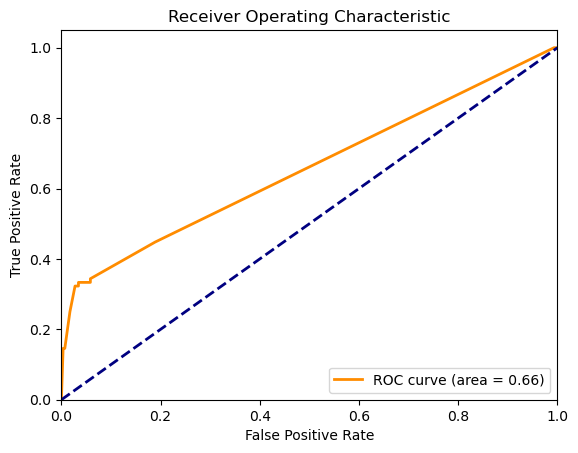

In [37]:
# Confusion matrix
y_true = predictions.select(['frontpage']).collect()
y_pred = predictions.select(['prediction']).collect()
confusion_matrix(y_true, y_pred)

# ROC curve
y_prob = predictions.select(['probability']).collect()
y_prob = np.array([x[0][1] for x in y_prob])
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
